**Character-Level Language Model: Bigram**

In [65]:
import torch, matplotlib.pyplot as plt, torch.nn.functional as F

In [118]:
words = open('names.txt', 'r').read().splitlines() #list of names

In [119]:
print(words[0])

emma


**First Approach: Counting**

In [120]:
N = torch.zeros((27, 27), dtype = torch.int32) #tensor of characters

In [121]:
#indexed list of alphabet (assuming words include all alphabet, otherwise import string)

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} #string to integer mapping
stoi['.'] = 0 #works as both <S> and <E> special tokens
itos = {i:s for s,i in stoi.items()}

In [122]:
#table of frequencies of a character comes after a character: N[1, 2] = frequency of "b" coming after "a"

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

In [123]:
len(N)

27

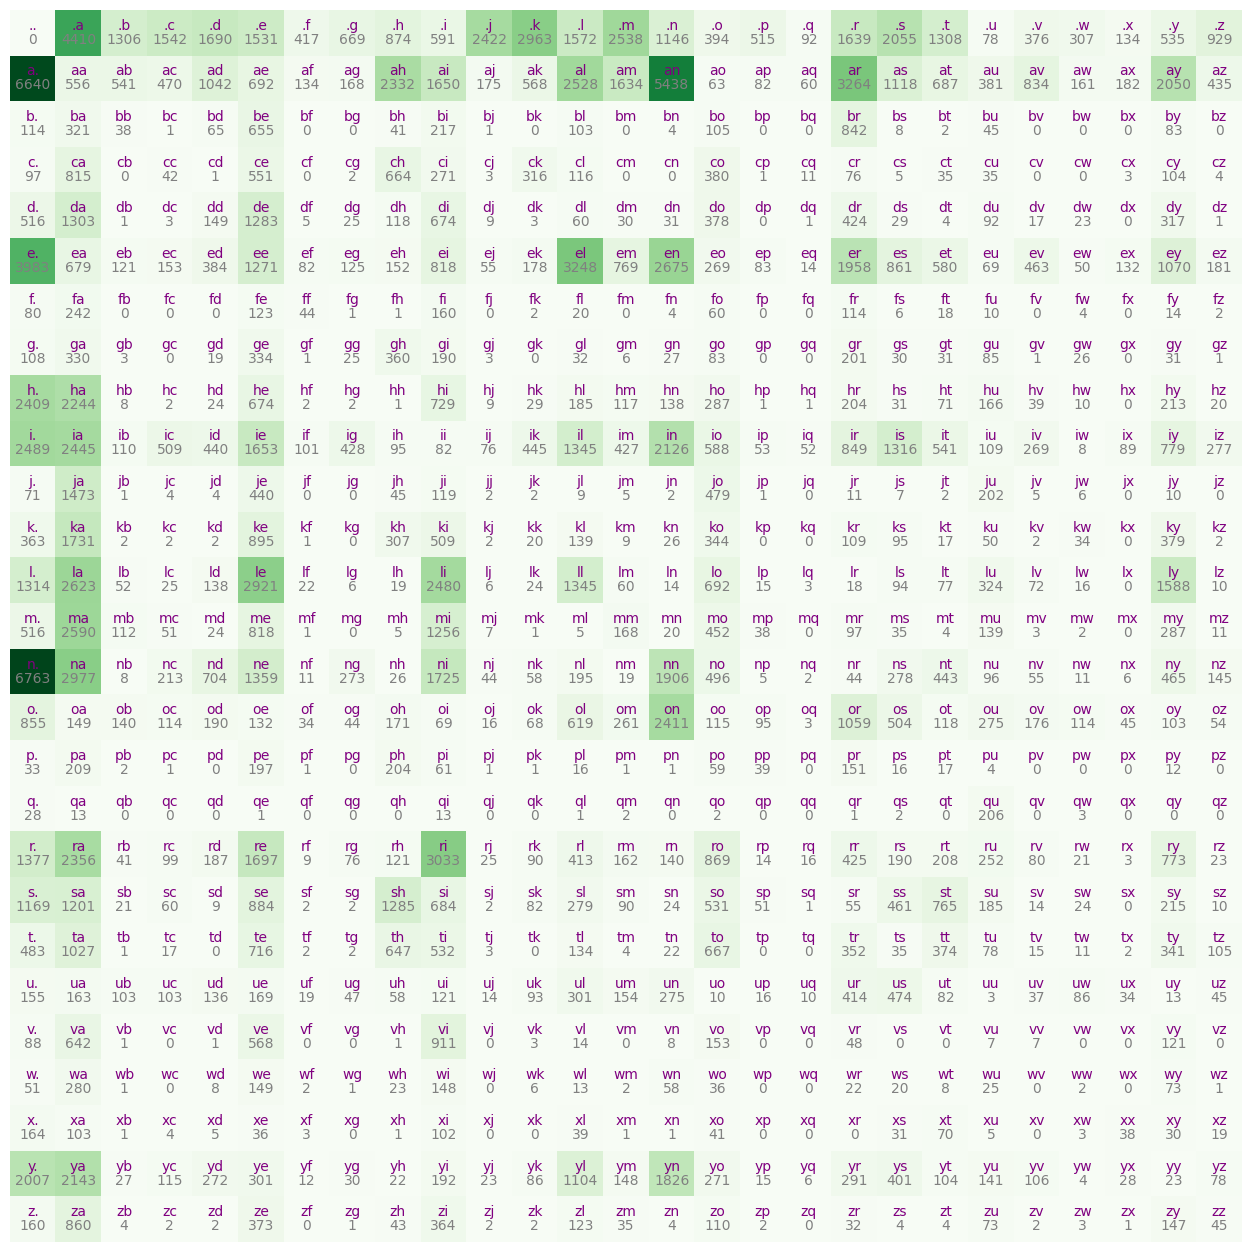

In [124]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Greens')
for i in range(len(N)):
    for j in range(len(N)):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='purple')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

**Sampling New Names:**

In [125]:
#convert frequencies to probabilities

P = (N+1).float() #param's of model + model smoothing
P /= P.sum(1, keepdims=True) 

In [144]:
#training model!

g = torch.Generator().manual_seed(2345654321) #deterministic result using Generator

for i in range(7):
    newName = []
    ix = 0
    while True:
        ix = torch.multinomial(P[ix], num_samples=1, replacement=True, generator=g).item()
        newName.append(itos[ix])
        if ix==0:
            break #here is reason for not taking back '.'
    print(''.join(newName))

ah.
milepra.
tosllifreremel.
ryde.
arylerir.
inargulinanyle.
colazaykesliell.


**Evaluation:**

In [138]:
#loss: negative log likelihood
loss = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        loss += -torch.log(prob)
        n += 1
print(f'{loss = }')
print(f'{loss/n}')

loss = tensor(559951.5625)
2.4543561935424805


**Second Approach: Single-Layer(!) Neural Network**

In [139]:
#training set of bigrams (x, y)

xs = [] #input: first character
ys = [] #output: second character (which is most likely to follow first character)/label
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs) #lower case tensor to get int to feed one-hot
ys = torch.tensor(ys)
num = xs.nelement()

In [140]:
#weights initialization

g = torch.Generator().manual_seed(2147481717)
w = torch.randn((27, 27), generator=g, requires_grad=True)

In [141]:
#gradient descent

for i in range(70):
    #forward pass
    xenc = F.one_hot(xs, num_classes=27).float() #encoding
    logits = xenc @ w
    #softmax
    counts = logits.exp() #equivalent to N
    probs = counts/counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(num), ys].log().mean()
    #backward pass
    w.grad = None
    loss.backward()
    w.data += -50 * w.grad
print(loss.item())

2.4841060638427734


**Sampling New Names:**

In [143]:
g = torch.Generator().manual_seed(2345654321)

for i in range(7):
  newName = []
  ix = 0
  while True:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ w
    counts = logits.exp()
    probs = counts/counts.sum(1, keepdims=True)
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    newName.append(itos[ix])
    if ix == 0:
      break
  print(''.join(newName))

ah.
milepza.
tosllifaliemel.
ryde.
arylerirxuxargulinanyle.
colazaykesliell.
a.
